<a href="https://colab.research.google.com/github/pmccthy/data-science-playground/blob/main/decompositions/pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Principal Component Analysis**

Principal Component Analysis (PCA) is essentially just SVD on the covariance matrix of whichever features you have. It finds the linear combinations of features which maximise explained variance (whilst forming an orthogonal basis set). These are given by the eigenpairs of the covariance matrix. Here, we will perform PCA on Fisher's iris dataset. An excellent explanation of how PCA is doing SVD under-the-hood can be found [here](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca/134283#134283?newreg=8784d739966c4fa0b242417c50c9a26b). PCA is a dimensionality reduction technique, and can be used for compression, denoising or as a step in a classification procedure (where classification becomes easier in principal component space), to name a few exmaples.

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import numpy as np

In [118]:
# load dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

Fisher's iris dataset consists of measurements for 150 flowers across 4 features (sepal length, sepal width, petal length, petal width), where each flower belongs to one of 3 species (Iris setosa, Iris virginica and Iris versicolor). This is evident in the dimensions of the input and target data (dependent and independent variables, respectively).

In [119]:
# check dimensions of data
print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (150, 4)
y: (150,)


This data is already in the format we expect when performing PCA, where we have a matrix of dimensions \[observations x features]

Text(0.5, 1.0, 'iris dataset')

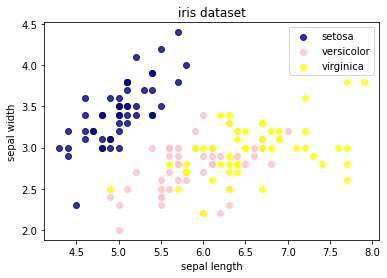

In [120]:
# plot data to view structure
colours = ['navy', 'pink', 'yellow']
for colour, i, target_name in zip(colours, [0, 1, 2], target_names):
    plt.scatter(X[y == i, 0], X[y == i, 1], color=colour, alpha=0.8, label=target_name)
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('iris dataset')

It is clear that there is some underlying structure to the data as datapoints belonging to different classes are clustered together. However, classes are intermixed so it would

**Perform PCA**

Roughly speaking, PCA consists of the following steps:


1.   Find the covariance matrix for your features
2.   Perform SVD (or eigendecomposition) on this matrix to find the principal directions and their loadings (given by the eigen-vectors and -values, respectively)
3.   Project the data into principal component space found by applying the transformation matrix (a linear summation of the original features)

In [121]:
# perform the PCA and project data onto two first PCs
pca = PCA(n_components=2)
pca_fitted = pca.fit(X) # find principal directions
PC = pca_fitted.transform(X) # project data onto principal direction vectors to obtain principal components

Text(0.5, 1.0, 'PCA on iris dataset')

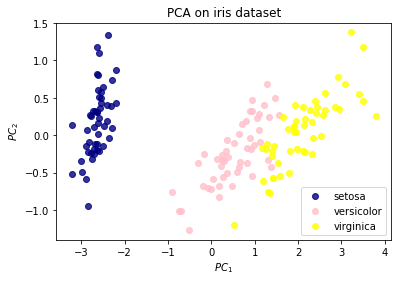

In [122]:
# visualise results
colours = ['navy', 'pink', 'yellow']
for colour, i, target_name in zip(colours, [0, 1, 2], target_names):
    plt.scatter(PC[y == i, 0], PC[y == i, 1], color=colour, alpha=0.8, label=target_name)
plt.xlabel('$PC_1$')
plt.ylabel('$PC_2$')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA on iris dataset')

let's look at the amount of variance explained by each PC (the eigenvalue corresponding to each PC as a proportion of the sum of eigenvalues)

In [123]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

This fits with our observation of the scatter plot above. Intuitively,  the classes are much more easily separable along the first PC than along the second.

**PCA denoising**

In [124]:
# generate sample data as if we have multiple channels recording the same phenomenon
num_channs = 10
fs = 100
T = 10
t_ax = np.arange(0,10,1/fs)
noise_var = np.random.random([num_channs, 1]) 
f = 1

# construct feature matrix [observations x features]
X = np.empty([len(t_ax), num_channs])
for feat in range(num_channs):
    X[:, feat] = np.sin(2 * np.pi * f * t_ax) + np.random.random([len(t_ax)]) * noise_var[feat]

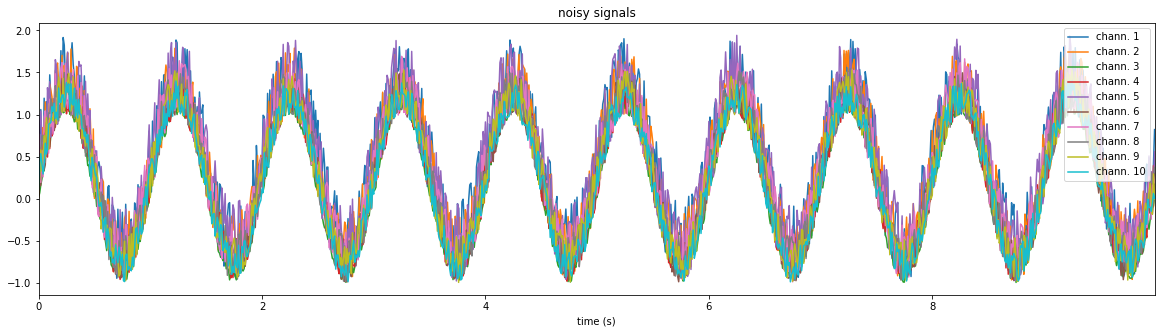

In [125]:
# plot signals 
plt.figure(figsize=(20,5))
for sig_idx in range(num_channs):
    plt.plot(t_ax, X[:, sig_idx], label=f'chann. {sig_idx+1}')
    plt.xlim([0, max(t_ax)])
    plt.xlabel('time (s)')
plt.title('noisy signals')
plt.legend()

In [126]:
# perform the PCA and project data onto two first PCs
pca = PCA()
pca_fitted = pca.fit(X) # find principal directions
PC = pca_fitted.transform(X) # project data onto principal direction vectors to obtain principal components

Text(0.5, 1.0, 'scree plot for PCs 0 to 10')

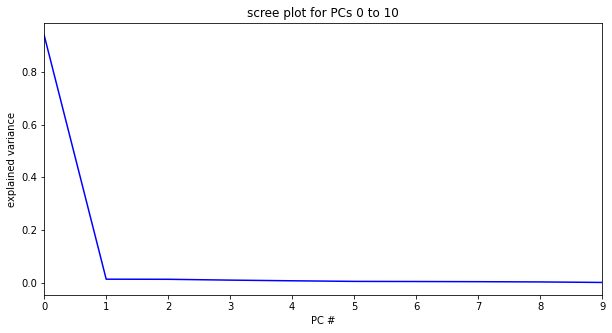

In [134]:
# scree plot
pc_show_range = [0,10]
plt.figure(figsize=(10,5))
plt.plot(pca.explained_variance_ratio_, c='b')
plt.ylabel('explained variance')
plt.xlabel('PC #')
plt.xlim([pc_show_range[0], pc_show_range[1]-1])
plt.title(f'scree plot for PCs {pc_show_range[0]} to {pc_show_range[1]}')

The elbow at PC 1 indicates that most of the variance is concentrated in PC 0, which we would expect to mean that our signal is concentrated in PC 0, whilst the other PCs contain noise. Let's plot the first few PCs to verify this.

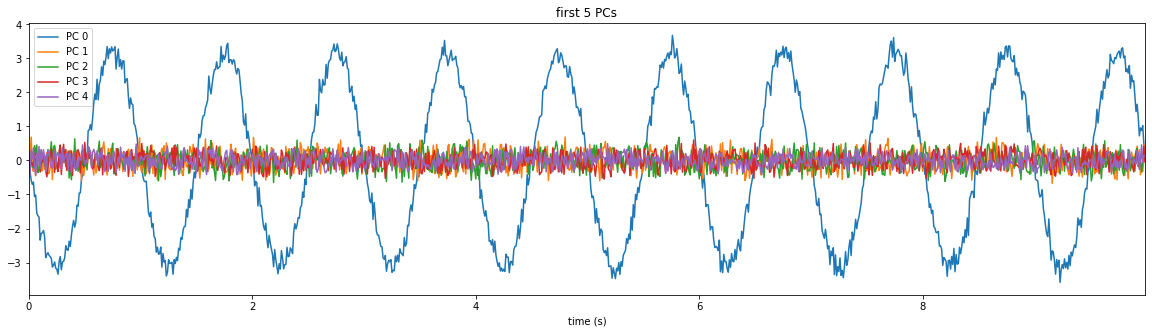

In [128]:
# plot the first few PCs
num_pcs = 5
plt.figure(figsize=(20,5))
for sig_idx in range(num_pcs):
    plt.plot(t_ax, PC[:, sig_idx], label=f'PC {sig_idx}')
    plt.xlim([0, max(t_ax)])
    plt.xlabel('time (s)')
plt.title(f'first {num_pcs} PCs')
plt.legend()

As expected, the variance corresponding to our signal is contained in PC 0, and the other components contain noise. Therefore, if we reject the noise PCs and reconstruct our signal, we should have a denoised signal for each channel.

In [129]:
# reject components
reject_range = [1,9]
PC_select = np.empty(np.shape(PC))
PC_select[:,:] = PC[:,:]
PC_select[:,reject_range[0]:reject_range[1]] = 0

In [130]:
X_recon = pca.inverse_transform(PC_select)

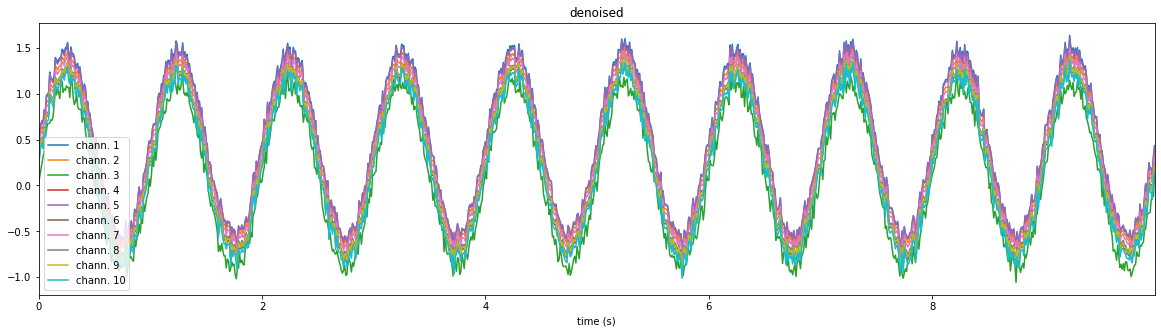

In [132]:
# plot signals 
plt.figure(figsize=(20,5))
for sig_idx in range(num_channs):
    plt.plot(t_ax, X_recon[:, sig_idx], label=f'chann. {sig_idx+1}')
    plt.xlim([0, max(t_ax)])
    plt.xlabel('time (s)')
plt.title('denoised')
plt.legend()

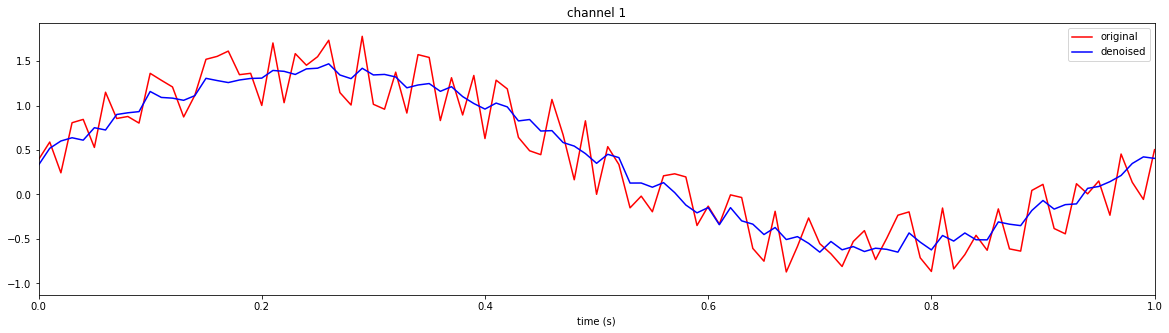

In [135]:
# plot a noisy and a denoised signal on the same plot for comparison
feat_idx = 1
plt.figure(figsize=(20,5))
plt.plot(t_ax, X[:, feat_idx], label='original', c='r')
plt.plot(t_ax, X_recon[:, feat_idx], label='denoised', c='b')
plt.xlim([0,1])
plt.xlabel('time (s)')
plt.title(f'channel {feat_idx}')
plt.legend()

Note that this approach is only valid if we expect each channel to be recording the same signal. If there is a variation between channels which could correspond to useful signal, then we risk this being lost in the 'noise' PCs, since it is variance which is not common to multiple features. This is simply a toy example that I came up with to illustrate performing PCA with time series data. 